In [1]:
import functools
import numpy as np
import scipy.optimize as opt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

rng = np.random.default_rng(93414286851068899262715314978330172806)

fig_format = "pdf"
savefig_opts = {
    "format": fig_format,
    "bbox_inches": "tight",
    "pad_inches": 0.0
}

In [2]:
def gaussian_kernel(X, Y, gamma):
    sq_norm = cdist(X, Y, 'sqeuclidean')
    return np.exp(-gamma * sq_norm)

In [3]:
def special_kernel(X, Y, eta):
    a = eta[0]
    b = eta[1]
    X_ = np.sin(2*np.pi*X.reshape(-1)+b)
    Y_ = np.sin(2*np.pi*Y.reshape(-1)+b)
    K = (1 + X @ Y.T)**2 + a * np.multiply.outer(X_, Y_)
    return K

In [4]:
def m(x):
    return np.zeros(np.array(x).shape)

# Part 1

In [5]:
def sample_GP(gamma, S, n_functions=1):
    # Turn each element of S into a 1-length array
    X = np.expand_dims(S, 1)
    # Compute kernel matrix
    cov = gaussian_kernel(X, X, gamma)
    ys = multivariate_normal.rvs(
        mean=m(S),
        cov=cov,
        size=n_functions,
        random_state=rng
    )
    return ys

In [6]:
def plot_GP(ax, S, Ys):
    for ys in Ys:
        ax.plot(S, ys, linestyle='-', marker=None)
    ax.set_xlabel('$x^*$')
    ax.set_ylabel('$f$')

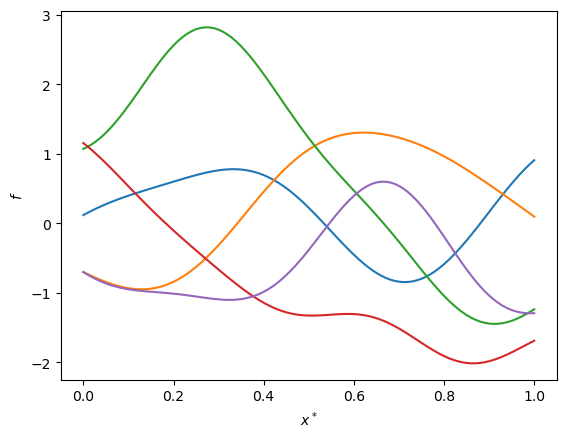

In [7]:
fig, ax = plt.subplots()
S = np.linspace(0, 1, 101)
Ys = sample_GP(gamma=10, S=S, n_functions=5)
plot_GP(ax, S, Ys)
fig.savefig(f"gp_samples.{fig_format}", **savefig_opts)

# Part 2

In [8]:
# Constants & hyperparameters
start_year = 1958
train_months = 10 * 12
predict_months = 6 * 12

In [9]:
def load_data(path):
    # 10 years of data for learning
    data = np.genfromtxt(path, delimiter=',')
    X = data[:train_months,2]-start_year
    y_raw = data[:train_months,3]
    y_mean = np.mean(y_raw)
    y_std = np.sqrt(np.var(y_raw))
    y = (y_raw-y_mean)/y_std
    # the next 5 years for prediction
    X_predict = data[train_months:train_months+predict_months,2]-start_year
    y_predict = data[train_months:train_months+predict_months,3]

    return X, y_raw, y, X_predict, y_predict

In [10]:
def negLogLikelihood(params, kernel, X, y):
    noise_y = params[0]
    eta = params[1:]
    N = len(y)
    K_S = kernel(X, X, eta)
    t1 = y.T @ np.linalg.inv(noise_y * np.eye(N) + K_S) @ y
    t2 = np.log(np.linalg.det(noise_y * np.eye(N) + K_S))
    t3 = N * np.log(np.sqrt(2 * np.pi))
    log_likelihood = -0.5 * (t1 + t2 + t3)
    return -log_likelihood

In [11]:
def optimize_params(ranges, kernel, Ngrid, X, y):
    opt_params = opt.brute(
        lambda params: negLogLikelihood(params, kernel, X, y),
        ranges,
        Ns=Ngrid,
        finish=None
    )
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta

In [12]:
def conditional(X, y, X_pred, noise_var, eta, kernel):
    N = len(X)
    # Here we denote `X` by `S` and `X_pred` by `x`,
    # like in eq. 75 of the lecture notes.
    K_S =  kernel(X, X, eta)
    K_Sx = kernel(X, X_pred, eta)
    K_xx = kernel(X_pred, X_pred, eta)
    G = np.linalg.inv(noise_var * np.eye(N) + K_S)
    a = G @ y
    mustar = K_Sx.T @ a
    Sigmastar = K_xx - K_Sx.T @ G @ K_Sx
    return mustar, Sigmastar # return mean and covariance matrix

In [13]:
def plot_prediction(
    ax,
    X, y_raw, X_predict, y_predict,
    prediction_mean_gp, var_gp
):
    ax.plot(X + start_year, y_raw, color='blue', label='training data')
    ax.plot(X_predict + start_year, y_predict, color='red', label='test data')
    y_mean = np.mean(y_raw)
    y_std  = np.sqrt(np.var(y_raw))
    yout_m = prediction_mean_gp*y_std + y_mean
    yout_v = var_gp*y_std**2
    ax.plot(X_predict + start_year, yout_m, color='black', label='gp prediction')
    ax.fill_between(
        X_predict + start_year,
        yout_m-1.96*yout_v**0.5,
        yout_m+1.96*yout_v**0.5,
        alpha=.5,
        color='grey',
        label='GP uncertainty'
    )
    ax.set_xlabel('year')
    ax.set_ylabel('co2(ppm)')
    ax.legend()

In [14]:
# Load data & expand it to have the right shape
S, y_raw, y, S_predict, y_predict = load_data('co2_mm_mlo.csv')
X = np.expand_dims(S, 1)
X_predict = np.expand_dims(S_predict, 1)

In [15]:
# Setup kernel and search space of parameters
kernel = special_kernel
# If `noise_var` is too low then `det|noise_var * I + K(S)|`
# is 0 and so the log-lokelihood will be -inf, so we keep `noise_var` > 0.005
#         noise_var    eta[0]      eta[1]
ranges = ((5.e-3,1), (1.e-4,10), (1.e-4,10))
Ngrid = 10

# Optimize parameters of kernel
noise_var, eta = optimize_params(ranges, kernel, Ngrid, X, y)
print("optimal params:", noise_var, eta)

optimal params: 0.11555555555555556 [1.1112 8.8889]


In [16]:
# Use GP to predict obervations on `X_predict`
prediction_mean_gp, Sigma_gp = conditional(X, y, X_predict, noise_var, eta, kernel)
# We only need the diagonal term of the covariance matrix for the plots.
var_gp = np.diag(Sigma_gp)

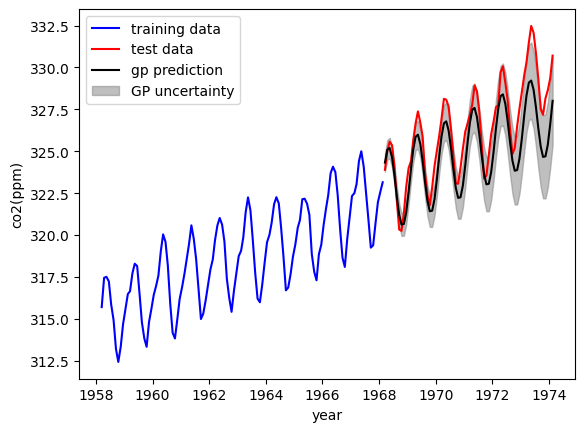

In [17]:
fig, ax = plt.subplots()
plot_prediction(
    ax,
    S, y_raw, S_predict, y_predict,
    prediction_mean_gp, var_gp
)
fig.savefig(f"gp_predict.{fig_format}", **savefig_opts)